In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special as sp
import math
import matplotlib as mpl

In [2]:
rho_lichid = 9.25 #kN/mc
H = 7.2 #m 
R = 9.42/2 #m
H_r = H/R #m
s = 5.4 #mm grosimea echivalenta
E = 210 * 10**3 #MPa
ag = 0.2 #g
Tc = 0.7 #s
gamma1w = 1.4 #factorul de importanta
q = 1.5 #factorul de comportare pentru presiunea impulsiva, la convectiva s-a folosit 1.
T = 0.11 #perioada rezervorului, dedus din SAP2000 de exemplu.

tabela2 = pd.read_excel('tabel_A2.xlsx')

display(tabela2)

def interpolate(xval, df, xcol, ycol):
# compute xval as the linear interpolation of xval where df is a dataframe and
#  df.x are the x coordinates, and df.y are the y coordinates. df.x is expected to be sorted.
    return np.interp([xval], df[xcol], df[ycol])

C1 = interpolate(H_r,tabela2,'H/R','C1')
Cc = interpolate(H_r,tabela2,'H/R','Cc')
mi_m = interpolate(H_r,tabela2,'H/R','mi/m')
mc_m = interpolate(H_r,tabela2,'H/R','mc/m')
hi_H = interpolate(H_r,tabela2,'H/R','hi/H')
hc_H = interpolate(H_r,tabela2,'H/R','hc/H')
hip_H = interpolate(H_r,tabela2,'H/R','hip/H')
hcp_H = interpolate(H_r,tabela2,'H/R','hcp/H')

print('Raportul H/r este',round(H_r,2))
print('C1 = ',C1)
print('Cc = ',Cc)
print('mi/m = ',mi_m)
print('mc/m = ',mc_m)
print('hi/H = ',hi_H)
print('hc/H = ',hc_H)
print('hip/H = ',hip_H)
print('hcp/H = ',hcp_H)

,H/R,C1,Cc,mi/m,mc/m,hi/H,hc/H,hip/H,hcp/H
0,0.3,9.28,2.09,0.176,0.824,0.400,0.521,2.640,3.414
1,0.5,7.74,1.74,0.300,0.700,0.400,0.543,1.460,1.517
2,0.7,6.97,1.60,0.414,0.586,0.401,0.571,1.009,1.011
3,1.0,6.36,1.52,0.548,0.452,0.419,0.616,0.721,0.785
4,1.5,6.06,1.48,0.686,0.314,0.439,0.690,0.555,0.734
5,2.0,6.21,1.48,0.763,0.237,0.448,0.751,0.500,0.764
6,2.5,6.56,1.48,0.810,0.190,0.452,0.794,0.480,0.796
7,3.0,7.03,1.48,0.842,0.158,0.453,0.825,0.472,0.825


Raportul H/r este 1.53
C1 =  [6.06859873]
Cc =  [1.48]
mi/m =  [0.69041401]
mc/m =  [0.30958599]
hi/H =  [0.43951592]
hc/H =  [0.69349682]
hip/H =  [0.55184713]
hcp/H =  [0.73571975]


perioada impulsiva Ti =  [0.08564376] s
perioada convectiva Tcon =   [3.21197509] s
Tc =  0.7 Tb =  0.14 Td =  3
ag =  0.2 g
Beta(t) =  [1.40145511]
Ag(t) =  [0.39419168] g


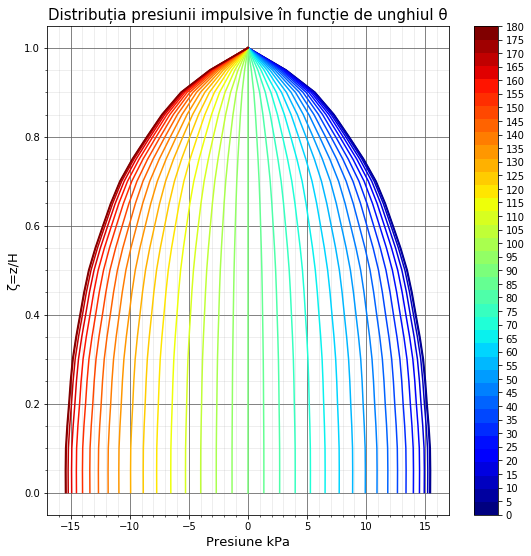

In [3]:
T_imp = C1 * np.sqrt(rho_lichid/10)/np.sqrt(s/R) * (H)/np.sqrt(E)
print('perioada impulsiva Ti = ',T_imp,'s')
T_con = Cc*np.sqrt(R)
print('perioada convectiva Tcon =  ',T_con,'s')
 
xi = np.linspace(0,1,10) #xi r/R
xi = 1
zeta = np.linspace(0,1,21) #zeta z/H
#print(zeta)
#xi si zeta sunt coordonate nondimensionale ale cilindrului

gamma = H/R
n = np.arange(0,10,1)
vn =  (2* np.arange(0,10,1) + 1)/2 * np.pi

Ci = np.zeros_like(zeta)

for i in range(len(zeta)):
    for j in range(len(n)):
        I1 = sp.iv(1,vn[j]/gamma*1)
        I1prim = sp.iv(0,vn[j]/gamma) - I1/(vn[j]/gamma)
        Ci[i] += (-1)**j/(I1prim * vn[j]**2) * np.cos(vn[j]*zeta[i]) * I1
    Ci[i] *=2

#Definirea încărcării seismice din P100-1/2013  

if Tc == 0.7:
    Tb = 0.14
    Td = 3
if Tc == 1:
    Tb = 0.2
    Td = 3
if Tc ==1.6:
    Tb = 0.32
    Td = 2
print('Tc = ',Tc,'Tb = ',Tb,'Td = ',Td)
print('ag = ',ag,'g')

if 0<=T_imp<=Tb:
    Beta_t = 1 + (2.5-1)/0.32 * T_imp
if Tb<T_imp<=Tc:
    Beta_t = 2.5
if Tc<T_imp<=Td:
    Beta_t = 2.5 *Tc/T_imp
if Td<T_imp:
    Beta_t = 2.5 * Tc*Td/T_imp**2
print('Beta(t) = ',Beta_t)



if 0<=T_imp<=Tb:
    Ag_t = gamma1w * ag*(1+ (2.5/q-1)/Tb * T_imp)
elif T>Tb:
    Ag_t = ag * Beta_t/q
    if Ag_t <= 0.2 * ag:
        Ag_t = 0.2 * ag
print('Ag(t) = ',Ag_t,'g')

plt.figure(figsize= (9,9))
teta = np.arange(0,185,5)
N = len(teta)
pi = np.zeros_like(zeta)

pi_s = np.zeros(shape = (len(teta),len(zeta)))


cmap = plt.get_cmap('jet',len(teta))

for i in range(len(teta)):
    pi = Ci * rho_lichid * H * Ag_t * np.cos(teta[i]*np.pi/180)
    pi_s[i] = pi
    plt.plot(pi,zeta,c = cmap(i))
    
plt.grid(b=True, which='major', color='#666666', linestyle='-')

# Show the minor grid lines with very faint and almost transparent grey lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Presiune kPa',size = 13)
plt.ylabel('ζ=z/H',size = 13)

norm = mpl.colors.Normalize(vmin=0,vmax=180)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(0,180,N), 
             boundaries=np.arange(-0.05,180.2,.1))
plt.title('Distribuția presiunii impulsive în funcție de unghiul θ',size = 15)


p_aplicat = np.zeros(shape = (len(teta),len(zeta)-1))

for i in range(len(p_aplicat)):
    for j in range(len(zeta)-1):
        p_aplicat[i][j] = (pi_s[i][j] + pi_s[i][j+1])/2

#print(p_aplicat)

np.savetxt("pimpulsiv.csv", p_aplicat, delimiter=",")
plt.savefig('pimpulsiv.svg')

### Presiunea convectiva

Perioada proprie de vibrație Tcn a modului convectiv [3.22 1.89 1.49]
η= 1.41
Beta =  [0.51 0.93 1.17]
Acn(t) =  [0.2  0.37 0.46]


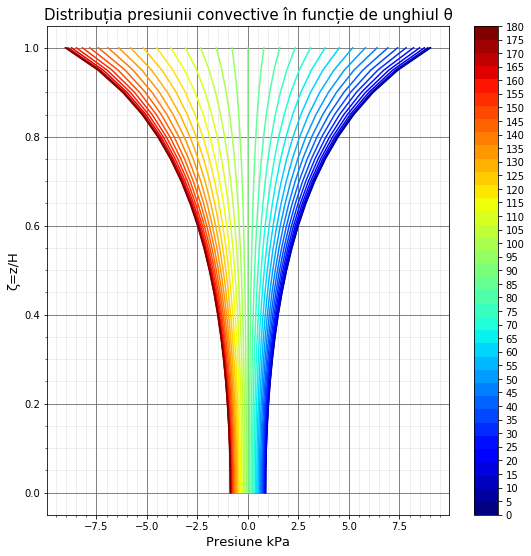

In [4]:
lambda1 = np.array([1.841,5.331,8.536])
Tcn = np.zeros_like(lambda1)
for i in range(len(lambda1)):
    Tcn[i] = 2 * np.pi * np.sqrt(R/(lambda1[i] * 9.81 * math.tanh(lambda1[i]*gamma)))
print('Perioada proprie de vibrație Tcn a modului convectiv',np.round(Tcn,2))
eta = np.sqrt(10/(5+0.5/100))
print('η=',np.round(eta,2))

def beta_t(T):
    if 0<=T<=Tb:
        Beta_t = 1 + (2.5-1)/0.32 * T
    if Tb<T<=Tc:
        Beta_t = 2.5
    if Tc<T<=Td:
        Beta_t = 2.5 *Tc/T
    if Td<T:
        Beta_t = 2.5 * Tc*Td/T**2
    return Beta_t

Beta_t = np.zeros_like(Tcn)
for i in range(len(Tcn)):
    Beta_t[i] = beta_t(Tcn[i])
    
print('Beta = ',np.round(Beta_t,2))
Sd_t = ag * Beta_t/1
Se_t = Sd_t * eta
Acn_t = gamma1w * Se_t
print('Acn(t) = ',np.round(Acn_t,2))

ksi1 = np.zeros_like(lambda1)
for i in range(len(lambda1)):
    ksi1[i] = (2*R) / ((lambda1[i]**2-1) * sp.jv(1,lambda1[i]) * math.cosh(lambda1[i]*gamma))


pc = np.zeros_like(zeta)

pc_s = np.zeros(shape = (len(teta),len(zeta)))

cmap = plt.get_cmap('jet',len(teta))


plt.figure(figsize= (9,9))

for j in range(len(teta)):
    for i in range(len(zeta)):
        suma = 0
        for w in range(len(lambda1)):          
            suma +=( ksi1[w] * math.cosh(lambda1[w] * gamma * zeta[i]) * sp.jv(1,lambda1[w]) 
                    * Acn_t[w] * np.cos(teta[j]*np.pi/180))
        pc[i] = rho_lichid * suma
    
    pc_s[j] = pc
    plt.plot(pc , zeta, c = cmap(j))


norm = mpl.colors.Normalize(vmin=0,vmax=180)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(0,180,N), 
             boundaries=np.arange(-0.05,180.2,.1))
plt.title('Distribuția presiunii convective în funcție de unghiul θ',size = 15)

plt.grid(b=True, which='major', color='#666666', linestyle='-')
# Show the minor grid lines with very faint and almost transparent grey lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Presiune kPa',size = 13)
plt.ylabel('ζ=z/H',size = 13)


p_aplicat = np.zeros(shape = (len(teta),len(zeta)-1))
for i in range(len(p_aplicat)):
    for j in range(len(zeta)-1):
        p_aplicat[i][j] = (pc_s[i][j] + pc_s[i][j+1])/2
#print(p_aplicat)
np.savetxt("pconvectiv.csv", p_aplicat, delimiter=",")
plt.savefig('pconvectiv.svg')

### Presiunea data de componenta verticala a actiunii seismice

avg =  0.14 g
Tbv =  0.0315 Tcv =  0.315 Tdv =  2
Av(t) =  0.36 g
Tvd =  0.1
[32.95 32.01 30.98 29.86 28.65 27.35 25.95 24.46 22.88 21.21 19.46 17.64
 15.74 13.78 11.76  9.69  7.58  5.44  3.27  1.09]


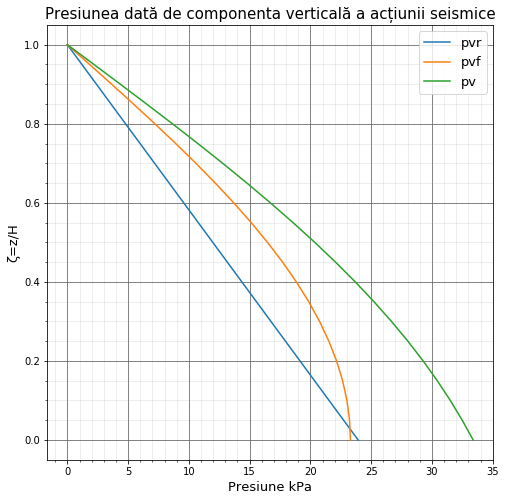

In [5]:
avg = 0.7 * ag
Tcv = 0.45 * Tc
Tbv = 0.1 * Tcv
Tdv = 2
print('avg = ',np.round(avg,2),'g')
print('Tbv = ',Tbv,'Tcv = ',Tcv,'Tdv = ',Tdv)
Beta_0v = 2.75
Sve_t = Beta_0v * avg / q * gamma1w

print('Av(t) = ',np.round(Sve_t,2),'g')

gamma1 = np.pi/(2*gamma)

fvd = 1/(4*R) * np.sqrt(2*E*sp.iv(1,gamma1)*s / (np.pi*rho_lichid*(1-0.3**2) * sp.iv(0,gamma1)))
Tvd = 1/fvd
print('Tvd = ',np.round(Tvd,2))

pvr = rho_lichid * H * (1-zeta) * Sve_t
fy = 1.078 + 0.274 * np.log(gamma)
pvf = 0.815 * fy * rho_lichid * H * np.cos(np.pi/2 * zeta) * Sve_t

pv = np.sqrt(pvf**2 + pvr**2)


plt.figure(figsize=(8,8))
plt.title('')
plt.plot(pvr,zeta,label = 'pvr')
plt.plot(pvf,zeta,label = 'pvf')
plt.plot(pv,zeta,label = 'pv')
plt.legend(loc = 'best',fontsize = 13)
plt.title('Presiunea dată de componenta verticală a acțiunii seismice',size = 15)

plt.grid(b=True, which='major', color='#666666', linestyle='-')
# Show the minor grid lines with very faint and almost transparent grey lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Presiune kPa',size = 13)
plt.ylabel('ζ=z/H',size = 13)

#print(np.round(pv,2))
pv_s = np.zeros(shape = len(zeta)-1)

for i in range(len(pv)-1):
    pv_s[i] = (pv[i]+pv[i+1])/2
print(np.round(pv_s,2))

np.savetxt("pvertical.csv", pv_s, delimiter=",")
plt.savefig('Presiunea_verticala.svg')

### Presiunea totala

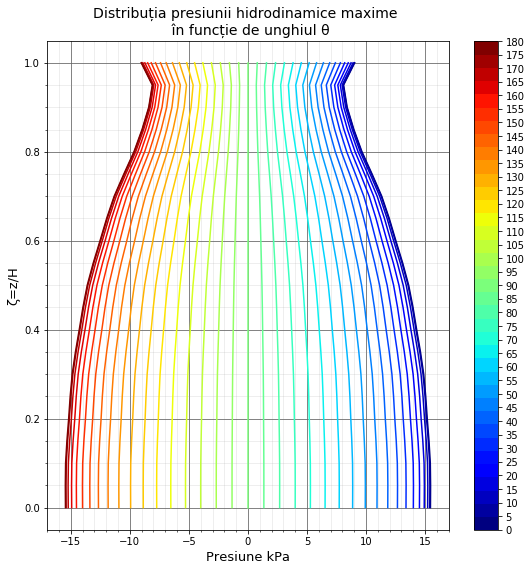

In [6]:
p_total = np.sqrt(pi_s**2 + pc_s**2)

cmap = plt.get_cmap('jet',len(teta))

plt.figure(figsize= (9,9))

for i in range(len(p_total)):
    if teta[i] <=90:
        plt.plot(p_total[i],zeta,c = cmap(i))
    if teta[i] > 90:
        plt.plot(-1*p_total[i],zeta,c = cmap(i))
        p_total[i] = -1 * p_total[i]
        
norm = mpl.colors.Normalize(vmin=0,vmax=180)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(0,180,N), 
             boundaries=np.arange(-0.05,180.2,.1))
plt.title('Distribuția presiunii hidrodinamice maxime \n în funcție de unghiul θ',size = 14)

plt.grid(b=True, which='major', color='#666666', linestyle='-')
# Show the minor grid lines with very faint and almost transparent grey lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Presiune kPa',size = 13)
plt.ylabel('ζ=z/H',size = 13)

plt.savefig('Presiunea totala(imp+conv).svg')

p_aplicat = np.zeros(shape = (len(teta),len(zeta)-1))

for i in range(len(p_aplicat)):
    for j in range(len(zeta)-1):
        p_aplicat[i][j] = (p_total[i][j] + p_total[i][j+1])/2

#print(p_aplicat)

np.savetxt("p_total.csv", p_aplicat, delimiter=",")